<a href="https://colab.research.google.com/github/ekaratnida/Automated_Tools-/blob/keep/Week13-simulation/Simpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install simpy library

In [ ]:
!pip install simpy

## Basic 1

In [ ]:
import simpy

def clock(env, name, tick):
     while True:
         print(name, env.now)
         yield env.timeout(tick)

env = simpy.Environment()
env.process(clock(env, 'fast', 0.5))
env.process(clock(env, 'slow', 1))
env.run(until=2)

fast 0
slow 0
fast 0.5
slow 1
fast 1.0
fast 1.5


Ex1. Add a new clock process.
___

## Basic 2

In [ ]:
def car(env):
  while True:
    print('Start parking at %d' % env.now)
    parking_duration = 5
    yield env.timeout(parking_duration)

    print('Start driving at %d' % env.now)
    trip_duration = 2
    yield env.timeout(trip_duration)

In [ ]:
env = simpy.Environment()
env.process(car(env))
env.run(until=15)

Start parking at 0
Start driving at 5
Start parking at 7
Start driving at 12
Start parking at 14


Ex2. Create a new car process with different parking and trip duration
___

# 2. Process Interaction (Parking and Charging)
## 2.1 Interrupting Another Process

In [ ]:
class Car(object):
     def __init__(self, env):
         self.env = env
         # Start the run process everytime an instance is created.
         self.action = env.process(self.run())

     def run(self):
         while True:
             print('Start parking and charging at %d' % self.env.now)
             charge_duration = 5
             # We yield the process that process() returns
             # to wait for it to finish
             yield self.env.process(self.charge(charge_duration))

             # The charge process has finished and
             # we can start driving again.
             print('Start driving at %d' % self.env.now)
             trip_duration = 2
             yield self.env.timeout(trip_duration)

     def charge(self, duration):
         yield self.env.timeout(duration)

In [ ]:
env = simpy.Environment()
car = Car(env)
env.run(until=15)

Start parking and charging at 0
Start driving at 5
Start parking and charging at 7
Start driving at 12
Start parking and charging at 14


Ex3. Create a new car with different charging and trip duration
___

## 2.2 Interrupting Another Process

### Imagine, you don’t want to wait until your electric vehicle is fully charged but want to interrupt the charging process and just start driving instead.

In [ ]:
class Car(object):
     def __init__(self, env):
         self.env = env
         # Start the run process everytime an instance is created.
         self.action = env.process(self.run())

     def run(self):
         while True:
            print('Start parking and charging at %d' % self.env.now)
            charge_duration = 5
            # We yield the process that process() returns
            # to wait for it to finish
            try:
              yield self.env.process(self.charge(charge_duration))
            except simpy.Interrupt:
              # When we received an interrupt, we stop charging and
              # switch to the "driving" state
              print('Was interrupted. Hope, the battery is full enough ...')

              # The charge process has finished and
              # we can start driving again.
              print('Start driving at %d' % self.env.now)
              trip_duration = 2
              yield self.env.timeout(trip_duration)

     def charge(self, duration):
         yield self.env.timeout(duration)

In [ ]:
def driver(env, car):
  yield env.timeout(3)
  car.action.interrupt()

In [ ]:
env = simpy.Environment()
car = Car(env)
env.process(driver(env, car))
env.run(until=15)

Start parking and charging at 0
Was interrupted. Hope, the battery is full enough ...
Start driving at 3
Start parking and charging at 5
Start parking and charging at 10


Ex4. Create a new interrupt event
___

# Key takeaways: waiting for a process and interrupting a process

# 3. Shared Resources

SimPy offers three types of resources that help you modeling problems, where multiple processes want to use a resource of limited capacity (e.g., cars at a fuel station with a limited number of fuel pumps) or classical producer-consumer problems.

In [ ]:
def car(env, name, bcs, driving_time, charge_duration):
     # Simulate driving to the BCS
     yield env.timeout(driving_time)

     # Request one of its charging spots
     print('%s arriving at %d' % (name, env.now))
     with bcs.request() as req:
         yield req

         # Charge the battery
         print('%s starting to charge at %s' % (name, env.now))
         yield env.timeout(charge_duration)
         print('%s leaving the bcs at %s' % (name, env.now))

In [ ]:
env = simpy.Environment()
bcs = simpy.Resource(env, capacity=2)
for i in range(4):
  env.process(car(env, 'Car %d' % i, bcs, i*2, 5))

In [ ]:
env.run()

Car 0 arriving at 0
Car 0 starting to charge at 0
Car 1 arriving at 2
Car 1 starting to charge at 2
Car 2 arriving at 4
Car 0 leaving the bcs at 5
Car 2 starting to charge at 5
Car 3 arriving at 6
Car 1 leaving the bcs at 7
Car 3 starting to charge at 7
Car 2 leaving the bcs at 10
Car 3 leaving the bcs at 12


Note that the first two cars can start charging immediately after they arrive at the BCS, while cars 2 and 3 have to wait.

Ex5. Increase and decrease the existing resources, observe the simulation.
___

# More real-case example (After break)
## 1. Bank Renege

This example models a bank counter and customers arriving at random times. Each customer has a certain patience. She waits to get to the counter until she’s at the end of her tether. If she gets to the counter, she uses it for a while before releasing it.
- Resources: Resource
- Condition events

In [ ]:
"""
Bank renege example

Covers:

- Resources: Resource
- Condition events

Scenario:
  A counter with a random service time and customers who renege. Based on the
  program bank08.py from TheBank tutorial of SimPy 2. (KGM)

"""
import random


RANDOM_SEED = 42
NEW_CUSTOMERS = 5  # Total number of customers
INTERVAL_CUSTOMERS = 10.0  # Generate new customers roughly every x seconds
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience


def source(env, number, interval, counter):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counter, time_in_bank=12.0)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counter, time_in_bank):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    print('%7.4f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE) # https://www.investopedia.com/terms/u/uniform-distribution.asp
        #print("patience = ", patience)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)
        #print("result = ",results)

        wait = env.now - arrive
        #print("wait = ",wait)

        if req in results:
            # We got to the counter
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

            tib = random.expovariate(1.0 / time_in_bank) # https://docs.python.org/3/library/random.html
            #print("tib ",tib)
            yield env.timeout(tib)
            print('%7.4f %s: Finished' % (env.now, name))

        else:
            # We reneged
            print('%7.4f %s: RENEGED after %6.3f' % (env.now, name, wait))


# Setup and start the simulation
print('Bank renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()

Bank renege
 0.0000 Customer00: Here I am
 0.0000 Customer00: Waited  0.000
 3.8595 Customer00: Finished
10.2006 Customer01: Here I am
10.2006 Customer01: Waited  0.000
12.7265 Customer02: Here I am
13.9003 Customer02: RENEGED after  1.174
23.7507 Customer01: Finished
34.9993 Customer03: Here I am
34.9993 Customer03: Waited  0.000
37.9599 Customer03: Finished
40.4798 Customer04: Here I am
40.4798 Customer04: Waited  0.000
43.1401 Customer04: Finished


Ex6. Change something to make customer happy (No renege)

**Poisson and Exponential distribution**

<b>Exponential distribution</b> is the time between events in a <b> Poisson process </b>. Simply, it is an inverse of Poisson. If the number of occurrences follows a Poisson distribution , the lapse of time between these events is distributed exponentially.

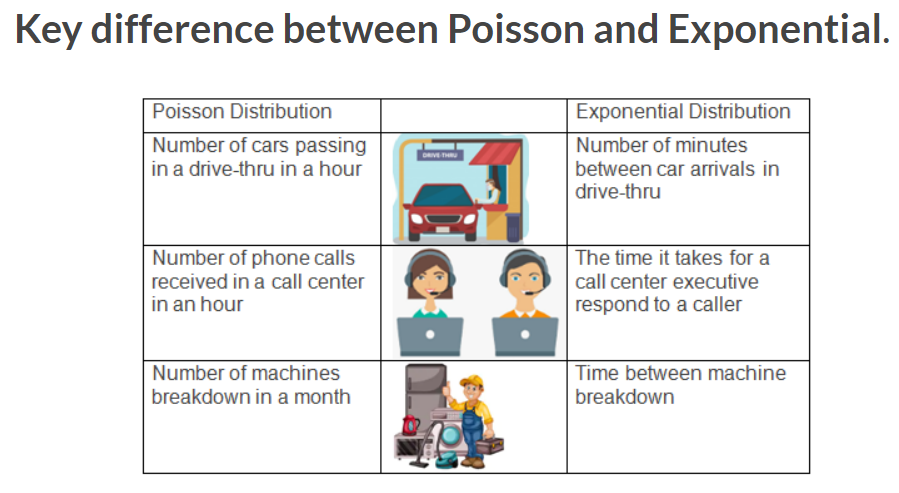

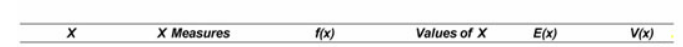
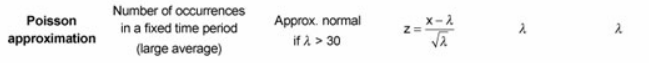

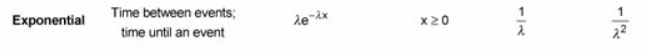

Reference

- https://www.kellogg.northwestern.edu/faculty/weber/decs-430/Notes%20on%20the%20Poisson%20and%20exponential%20distributions.pdf
- https://sixsigmastudyguide.com/poisson-distribution/
- https://sixsigmastudyguide.com/exponential-distribution/


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


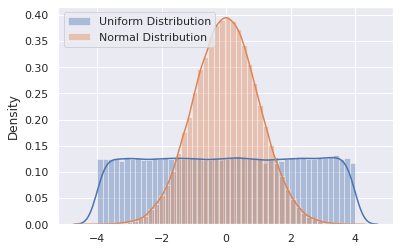

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.simplefilter("ignore", UserWarning)

# Let's create an array of random numbers from uniform distribution
uniform = np.random.uniform(-4,4,100000)

# Let's create an array of random numbers from normal distribution
normal = np.random.randn(100000)

# Let's plot them
ax = sns.distplot(uniform, label='Uniform Distribution')
bx = sns.distplot(normal, label= 'Normal Distribution')
legend = plt.legend()
plt.show()

# 2. Carwash

The Carwash example is a simulation of a carwash with a limited number of machines and a number of cars that arrive at the carwash to get cleaned.
- Waiting for other processes
- Resources: Resource

In [ ]:
"""
Carwash example.

Covers:

- Waiting for other processes
- Resources: Resource

Scenario:
  A carwash has a limited number of washing machines and defines
  a washing processes that takes some (random) time.

  Car processes arrive at the carwash at a random time. If one washing
  machine is available, they start the washing process and wait for it
  to finish. If not, they wait until they an use one.

"""


RANDOM_SEED = 42
NUM_MACHINES = 2  # Number of machines in the carwash
WASHTIME = 5      # Minutes it takes to clean a car
T_INTER = 7       # Create a car every ~7 minutes
SIM_TIME = 20     # Simulation time in minutes


class Carwash(object):
    """A carwash has a limited number of machines (``NUM_MACHINES``) to
    clean cars in parallel.

    Cars have to request one of the machines. When they got one, they
    can start the washing processes and wait for it to finish (which
    takes ``washtime`` minutes).

    """
    def __init__(self, env, num_machines, washtime):
        self.env = env
        self.machine = simpy.Resource(env, num_machines)
        self.washtime = washtime

    def wash(self, car):
        """The washing processes. It takes a ``car`` processes and tries
        to clean it."""
        yield self.env.timeout(WASHTIME)
        print("Carwash removed %d%% of %s's dirt." %
              (random.randint(50, 99), car))


def car(env, name, cw):
    """The car process (each car has a ``name``) arrives at the carwash
    (``cw``) and requests a cleaning machine.

    It then starts the washing process, waits for it to finish and
    leaves to never come back ...

    """
    print('%s arrives at the carwash at %.2f.' % (name, env.now))
    with cw.machine.request() as request:
        yield request

        print('%s enters the carwash at %.2f.' % (name, env.now))
        yield env.process(cw.wash(name))

        print('%s leaves the carwash at %.2f.' % (name, env.now))


def setup(env, num_machines, washtime, t_inter):
    """Create a carwash, a number of initial cars and keep creating cars
    approx. every ``t_inter`` minutes."""
    # Create the carwash
    carwash = Carwash(env, num_machines, washtime)

    # Create 4 initial cars
    for i in range(4):
        env.process(car(env, 'Car %d' % i, carwash))

    # Create more cars while the simulation is running
    while True:
        yield env.timeout(random.randint(t_inter - 2, t_inter + 2))
        i += 1
        env.process(car(env, 'Car %d' % i, carwash))


# Setup and start the simulation
print('Carwash')
print('Check out http://youtu.be/fXXmeP9TvBg while simulating ... ;-)')
random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_MACHINES, WASHTIME, T_INTER))

# Execute!
env.run(until=SIM_TIME)

Carwash
Check out http://youtu.be/fXXmeP9TvBg while simulating ... ;-)
Car 0 arrives at the carwash at 0.00.
Car 1 arrives at the carwash at 0.00.
Car 2 arrives at the carwash at 0.00.
Car 3 arrives at the carwash at 0.00.
Car 0 enters the carwash at 0.00.
Car 1 enters the carwash at 0.00.
Car 4 arrives at the carwash at 5.00.
Carwash removed 97% of Car 0's dirt.
Carwash removed 67% of Car 1's dirt.
Car 0 leaves the carwash at 5.00.
Car 1 leaves the carwash at 5.00.
Car 2 enters the carwash at 5.00.
Car 3 enters the carwash at 5.00.
Car 5 arrives at the carwash at 10.00.
Carwash removed 64% of Car 2's dirt.
Carwash removed 58% of Car 3's dirt.
Car 2 leaves the carwash at 10.00.
Car 3 leaves the carwash at 10.00.
Car 4 enters the carwash at 10.00.
Car 5 enters the carwash at 10.00.
Carwash removed 97% of Car 4's dirt.
Carwash removed 56% of Car 5's dirt.
Car 4 leaves the carwash at 15.00.
Car 5 leaves the carwash at 15.00.
Car 6 arrives at the carwash at 16.00.
Car 6 enters the carwash 

#3. Machine Shop

This example comprises a workshop with n identical machines. A stream of jobs (enough to keep the machines busy) arrives. Each machine breaks down periodically. Repairs are carried out by one repairman. The repairman has other, less important tasks to perform, too. Broken machines preempt theses tasks. The repairman continues them when he is done with the machine repair. The workshop works continuously.
- Interrupts
- Resources: PreemptiveResource

In [ ]:
"""
Machine shop example

Covers:

- Interrupts
- Resources: PreemptiveResource

Scenario:
  A workshop has *n* identical machines. A stream of jobs (enough to
  keep the machines busy) arrives. Each machine breaks down
  periodically. Repairs are carried out by one repairman. The repairman
  has other, less important tasks to perform, too. Broken machines
  preempt theses tasks. The repairman continues them when he is done
  with the machine repair. The workshop works continuously.

"""


RANDOM_SEED = 42
PT_MEAN = 10.0         # Avg. processing time in minutes
PT_SIGMA = 2.0         # Sigma of processing time
MTTF = 300.0           # Mean time to failure in minutes
BREAK_MEAN = 1 / MTTF  # Param. for expovariate distribution
REPAIR_TIME = 30.0     # Time it takes to repair a machine in minutes
JOB_DURATION = 30.0    # Duration of other jobs in minutes
NUM_MACHINES = 10      # Number of machines in the machine shop
WEEKS = 4              # Simulation time in weeks
SIM_TIME = WEEKS * 7 * 24 * 60  # Simulation time in minutes


def time_per_part():
    """Return actual processing time for a concrete part."""
    return random.normalvariate(PT_MEAN, PT_SIGMA)


def time_to_failure():
    """Return time until next failure for a machine."""
    return random.expovariate(BREAK_MEAN)


class Machine(object):
    """A machine produces parts and my get broken every now and then.

    If it breaks, it requests a *repairman* and continues the production
    after the it is repaired.

    A machine has a *name* and a numberof *parts_made* thus far.

    """
    def __init__(self, env, name, repairman):
        self.env = env
        self.name = name
        self.parts_made = 0
        self.broken = False

        # Start "working" and "break_machine" processes for this machine.
        self.process = env.process(self.working(repairman))
        env.process(self.break_machine())

    def working(self, repairman):
        """Produce parts as long as the simulation runs.

        While making a part, the machine may break multiple times.
        Request a repairman when this happens.

        """
        while True:
            # Start making a new part
            done_in = time_per_part()
            while done_in:
                try:
                    # Working on the part
                    start = self.env.now
                    yield self.env.timeout(done_in)
                    done_in = 0  # Set to 0 to exit while loop.

                except simpy.Interrupt:
                    self.broken = True
                    done_in -= self.env.now - start  # How much time left?

                    # Request a repairman. This will preempt its "other_job".
                    with repairman.request(priority=1) as req:
                        yield req
                        yield self.env.timeout(REPAIR_TIME)

                    self.broken = False

            # Part is done.
            self.parts_made += 1

    def break_machine(self):
        """Break the machine every now and then."""
        while True:
            yield self.env.timeout(time_to_failure())
            if not self.broken:
                # Only break the machine if it is currently working.
                self.process.interrupt()


def other_jobs(env, repairman):
    """The repairman's other (unimportant) job."""
    while True:
        # Start a new job
        done_in = JOB_DURATION
        while done_in:
            # Retry the job until it is done.
            # It's priority is lower than that of machine repairs.
            with repairman.request(priority=2) as req:
                yield req
                try:
                    start = env.now
                    yield env.timeout(done_in)
                    done_in = 0
                except simpy.Interrupt:
                    done_in -= env.now - start


# Setup and start the simulation
print('Machine shop')
random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()
repairman = simpy.PreemptiveResource(env, capacity=1)
machines = [Machine(env, 'Machine %d' % i, repairman)
            for i in range(NUM_MACHINES)]
env.process(other_jobs(env, repairman))

# Execute!
env.run(until=SIM_TIME)

# Analyis/results
print('Machine shop results after %s weeks' % WEEKS)
for machine in machines:
    print('%s made %d parts.' % (machine.name, machine.parts_made))

Machine shop
Machine shop results after 4 weeks
Machine 0 made 3251 parts.
Machine 1 made 3273 parts.
Machine 2 made 3242 parts.
Machine 3 made 3343 parts.
Machine 4 made 3387 parts.
Machine 5 made 3244 parts.
Machine 6 made 3269 parts.
Machine 7 made 3185 parts.
Machine 8 made 3302 parts.
Machine 9 made 3279 parts.


# 4. Movie renege
This examples models a movie theater with one ticket counter selling tickets for three movies (next show only). People arrive at random times and try to buy a random number (1–6) of tickets for a random movie. When a movie is sold out, all people waiting to buy a ticket for that movie renege (leave the queue).
- Resources: Resource
- Condition events
- Shared events

In [ ]:
"""
Movie renege example

Covers:

- Resources: Resource
- Condition events
- Shared events

Scenario:
  A movie theatre has one ticket counter selling tickets for three
  movies (next show only). When a movie is sold out, all people waiting
  to buy tickets for that movie renege (leave queue).

"""
import collections


RANDOM_SEED = 42
TICKETS = 50  # Number of tickets per movie
SIM_TIME = 120  # Simulate until


def moviegoer(env, movie, num_tickets, theater):
    """A moviegoer tries to by a number of tickets (*num_tickets*) for
    a certain *movie* in a *theater*.

    If the movie becomes sold out, she leaves the theater. If she gets
    to the counter, she tries to buy a number of tickets. If not enough
    tickets are left, she argues with the teller and leaves.

    If at most one ticket is left after the moviegoer bought her
    tickets, the *sold out* event for this movie is triggered causing
    all remaining moviegoers to leave.

    """
    with theater.counter.request() as my_turn:
        # Wait until its our turn or until the movie is sold out
        result = yield my_turn | theater.sold_out[movie]

        # Check if it's our turn or if movie is sold out
        if my_turn not in result:
            theater.num_renegers[movie] += 1
            return

        # Check if enough tickets left.
        if theater.available[movie] < num_tickets:
            # Moviegoer leaves after some discussion
            yield env.timeout(0.5)
            return

        # Buy tickets
        theater.available[movie] -= num_tickets
        if theater.available[movie] < 2:
            # Trigger the "sold out" event for the movie
            theater.sold_out[movie].succeed()
            theater.when_sold_out[movie] = env.now
            theater.available[movie] = 0
        yield env.timeout(1)


def customer_arrivals(env, theater):
    """Create new *moviegoers* until the sim time reaches 120."""
    while True:
        yield env.timeout(random.expovariate(1 / 0.5))

        movie = random.choice(theater.movies)
        num_tickets = random.randint(1, 6)
        if theater.available[movie]:
            env.process(moviegoer(env, movie, num_tickets, theater))


Theater = collections.namedtuple('Theater', 'counter, movies, available, '
                                            'sold_out, when_sold_out, '
                                            'num_renegers')


# Setup and start the simulation
print('Movie renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Create movie theater
counter = simpy.Resource(env, capacity=1)
movies = ['Python Unchained', 'Kill Process', 'Pulp Implementation']
available = {movie: TICKETS for movie in movies}
sold_out = {movie: env.event() for movie in movies}
when_sold_out = {movie: None for movie in movies}
num_renegers = {movie: 0 for movie in movies}
theater = Theater(counter, movies, available, sold_out, when_sold_out,
                  num_renegers)

# Start process and run
env.process(customer_arrivals(env, theater))
env.run(until=SIM_TIME)

# Analysis/results
for movie in movies:
    if theater.sold_out[movie]:
        print('Movie "%s" sold out %.1f minutes after ticket counter '
              'opening.' % (movie, theater.when_sold_out[movie]))
        print('  Number of people leaving queue when film sold out: %s' %
              theater.num_renegers[movie])

Movie renege
Movie "Python Unchained" sold out 38.0 minutes after ticket counter opening.
  Number of people leaving queue when film sold out: 16
Movie "Kill Process" sold out 43.0 minutes after ticket counter opening.
  Number of people leaving queue when film sold out: 5
Movie "Pulp Implementation" sold out 28.0 minutes after ticket counter opening.
  Number of people leaving queue when film sold out: 5
